Data Pre-processing

In [1]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('layer_9_train.csv')
valid_data = pd.read_csv('layer_9_valid.csv')
test_data = pd.read_csv('layer_9_test.csv')

Define label columns and Prepare the training and validation data

In [2]:
label_columns = ['label_1', 'label_2', 'label_3', 'label_4']

df_train_X = train_data.drop(label_columns, axis=1)
df_train_y = train_data['label_3']
df_valid_X = valid_data.drop(label_columns, axis=1)
df_valid_y = valid_data['label_3']

<Axes: xlabel='label_3'>

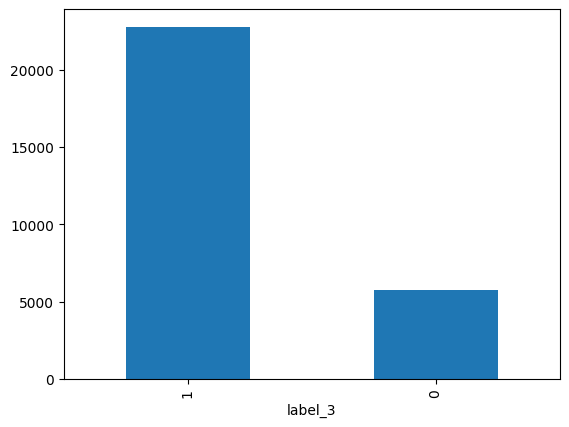

In [3]:
df_train_y.value_counts().plot(kind='bar')

Standardize the data

In [4]:
from sklearn.svm import SVC

model_initial = SVC(kernel='rbf', C=1.0, gamma='scale')
model_initial.fit(df_train_X, df_train_y)

y_pred_initial = model_initial.predict(df_valid_X)

from sklearn.metrics import accuracy_score

accuracy_initial = accuracy_score(df_valid_y, y_pred_initial)
print("Initial Accuracy:", accuracy_initial)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train_X_scaled = scaler.fit_transform(df_train_X)
df_valid_X_scaled = scaler.transform(df_valid_X)

print(df_train_X_scaled.shape)

(28520, 768)


Train an initial SVC model

In [6]:
from sklearn.svm import SVC

model_initial = SVC(kernel='rbf', C=1.0, gamma='scale')
model_initial.fit(df_train_X_scaled, df_train_y)

y_pred_initial = model_initial.predict(df_valid_X_scaled)

Predict and find the accuracy

In [7]:
from sklearn.metrics import accuracy_score

accuracy_initial = accuracy_score(df_valid_y, y_pred_initial)
print("Initial Accuracy:", accuracy_initial)

Initial Accuracy: 0.9973333333333333


Use SelectKBest to select the top k features

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

k_best = SelectKBest(score_func=f_classif, k=500)
df_train_X_selected = k_best.fit_transform(df_train_X_scaled, df_train_y)
df_valid_X_selected = k_best.transform(df_valid_X_scaled)

Apply PCA to reduce dimensionality

In [9]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
pca.fit(df_train_X_selected)
pca_train_X = pca.transform(df_train_X_selected)
pca_valid_X = pca.transform(df_valid_X_selected)

print(pca_train_X.shape)

(28520, 243)


Train a SVC model after feature selection and PCA and Predict on the validation set

In [10]:
model_after = SVC(kernel='rbf', C=1.0, gamma='scale')
model_after.fit(pca_train_X, df_train_y)

y_pred_after = model_after.predict(pca_valid_X)

Calculate accuracy after feature selection and PCA

In [11]:
from sklearn.metrics import accuracy_score

accuracy_after = accuracy_score(df_valid_y, y_pred_after)
print("Accuracy after Feature Selection and PCA:", accuracy_after)

Accuracy after Feature Selection and PCA: 0.996


Randomized search for hyperparameter tuning

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distributions for SVC
param_dist = {
    'C': [0.1, 1, 10],               # Adjust the list of values to sample
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=2,  # Number of random combinations to try
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

random_search.fit(pca_train_X, df_train_y)

Get the best parameters and estimator from the randomized search

In [ ]:
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

Predict on the validation set using the tuned model and find the tuned accuracy

In [ ]:
y_pred_tuned = best_estimator.predict(pca_valid_X)

# Calculate tuned accuracy
accuracy_tuned = accuracy_score(df_valid_y, y_pred_tuned)
print("Tuned Accuracy:", accuracy_tuned)

Tuned Accuracy: 0.9933333333333333


In [ ]:
# Scale the test data using the same scaler that was fitted on the training data
df_test_X_scaled = scaler.transform(test_data)

# Select the same features using SelectKBest
df_test_X_selected = k_best.transform(df_test_X_scaled)

# Transform the test data using the same PCA model
pca_test_X = pca.transform(df_test_X_selected)

# Use the best-tuned model for predictions on the test data
y_pred_test = best_estimator.predict(pca_test_X)

# Assuming 'y_pred_test' is a numpy array or a list
predictions_df = pd.DataFrame({'Predictions': y_pred_test})

predictions_df.to_csv('svm_predictions_label_3-Layer9.csv', index=False)